In [1]:
import tensorflow as tf
from tensorflow import keras
from json import loads
import pandas as pd
from keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from ast import literal_eval
import pickle

2024-01-03 04:00:16.326028: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 04:00:16.400537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 04:00:16.400596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 04:00:16.400645: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 04:00:16.420519: I tensorflow/core/platform/cpu_feature_g

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# import gdown
# url = 'https://drive.google.com/uc?id=1KJy0q8wlXvpmWswO2tpGzwAlNDTB_L6F'
# output = 'my_dict.pkl'

# gdown.download(url, output, quiet=False)

In [5]:
with open('my_dict.pkl', 'rb') as f:
    my_dict = pickle.load(f)
my_dict
x=[]
y=[]
for i in my_dict:
    y.append(i['speaker'])
    x.append(i['cepstrum'])
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# create an example list of labels
labels = y
# create a LabelEncoder object
le = LabelEncoder()
# fit the encoder to the labels and transform the labels
y = le.fit_transform(labels)
print(len(le.classes_))
# print the original labels and the encoded labels
print("Original labels:", labels)
print("Encoded labels:", y)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
# Save the encoded data as a NumPy array
np.save('encoded_data.npy', y)
x=np.array(x)


y_train, y_test, x_train, x_test = train_test_split(y, x, test_size=0.2, stratify=y, random_state=42)

251
Original labels: [' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen Savage', ' Karen S

In [6]:
x.shape

(48441, 40, 400)

Build Transformer model


In [7]:
from keras import layers, regularizers
timestep=x.shape[2]
feature=x.shape[1]
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, l2_reg=0.0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
    kernel_regularizer=regularizers.l2(l2_reg))(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dropout(dropout)(x)
    # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.0,
    mlp_dropout=0.0,
    l2_reg=0.0
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Permute((2, 1), input_shape=(feature,timestep ))(x)
    x = layers.Conv1D(filters=40, kernel_size=201,activation='relu', name="Conv1D_1",kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Permute((2, 1), input_shape=(200,feature ))(x)
    x = layers.Dropout(dropout)(x)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.Permute((2, 1), input_shape=(feature,200 ))(x)
    x = layers.Conv1D(filters=40, kernel_size=101,activation='relu', name="Conv1D_2",kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Permute((2, 1), input_shape=(100,feature ))(x)
    x = layers.Dropout(dropout)(x)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    # x = layers.Permute((2, 1), input_shape=(feature,100 ))(x)
    # x = layers.Conv1D(filters=40, kernel_size=51,activation='relu', name="Conv1D_3",kernel_regularizer=regularizers.l2(l2_reg))(x)
    # x = layers.Permute((2, 1), input_shape=(50,feature ))(x)
    # x = layers.Dropout(dropout)(x)
    # x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Dense(mlp_units, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(len(le.classes_), activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [8]:
x.shape


(48441, 40, 400)

In [9]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.1


In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=128,
    mlp_dropout=0.4,
    dropout=0.4,
    l2_reg=0.001
)
# Set the initial learning rate, total number of training steps, and number of warmup steps
initial_learning_rate = 4e-5
total_steps = 600000
warmup_steps = 40000

# Create a learning rate schedule with cosine annealing and warmup
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=total_steps - warmup_steps,
    alpha=4e-6  # Minimum learning rate, usually set to 0
)

# Optionally, add warmup to the learning rate schedule
def warmup_lr_schedule(step):
    if step < warmup_steps:
        return initial_learning_rate * (step / warmup_steps)
    else:
        return lr_schedule(step - warmup_steps)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)]
# plt.plot(range(total_steps), [warmup_lr_schedule(step) for step in range(total_steps)])
# plt.xlabel('Training Steps')
# plt.ylabel('Learning Rate')
# plt.show()

history=model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=360,
    batch_size=16,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

2024-01-03 04:00:32.615449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28857 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 400)]            0         []                            
                                                                                                  
 permute (Permute)           (None, 400, 40)              0         ['input_1[0][0]']             
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 200, 40)              321640    ['permute[0][0]']             
                                                                                                  
 permute_1 (Permute)         (None, 40, 200)              0         ['Conv1D_1[0][0]']            
                                                                                              

2024-01-03 04:00:48.953926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-01-03 04:01:00.878955: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8bf19af690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 04:01:00.878999: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-01-03 04:01:00.887211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-03 04:01:01.696852: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1938/1938 [==============================] - 61s 16ms/step - loss: 5.6629 - sparse_categorical_accuracy: 0.0085 - val_loss: 5.5830 - val_sparse_categorical_accuracy: 0.0230
Epoch 2/360
1938/1938 [==============================] - 32s 17ms/step - loss: 5.3556 - sparse_categorical_accuracy: 0.0237 - val_loss: 5.0317 - val_sparse_categorical_accuracy: 0.0470
Epoch 3/360
1938/1938 [==============================] - 32s 17ms/step - loss: 4.8587 - sparse_categorical_accuracy: 0.0478 - val_loss: 4.5079 - val_sparse_categorical_accuracy: 0.0837
Epoch 4/360
1938/1938 [==============================] - 30s 15ms/step - loss: 4.4409 - sparse_categorical_accuracy: 0.0767 - val_loss: 4.0362 - val_sparse_categorical_accuracy: 0.1352
Epoch 5/360
1938/1938 [==============================] - 29s 15ms/step - loss: 4.0486 - sparse_categorical_accuracy: 0.1135 - val_loss: 3.5559 - val_sparse_categorical_accuracy: 0.2024
Epoch 6/360
1938/1938 [==============================] - 31s 16ms/step - loss: 3.7230 -

[0.5710120797157288, 0.8843017816543579]

In [11]:
model.save('model.h5')

/home/trungct/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


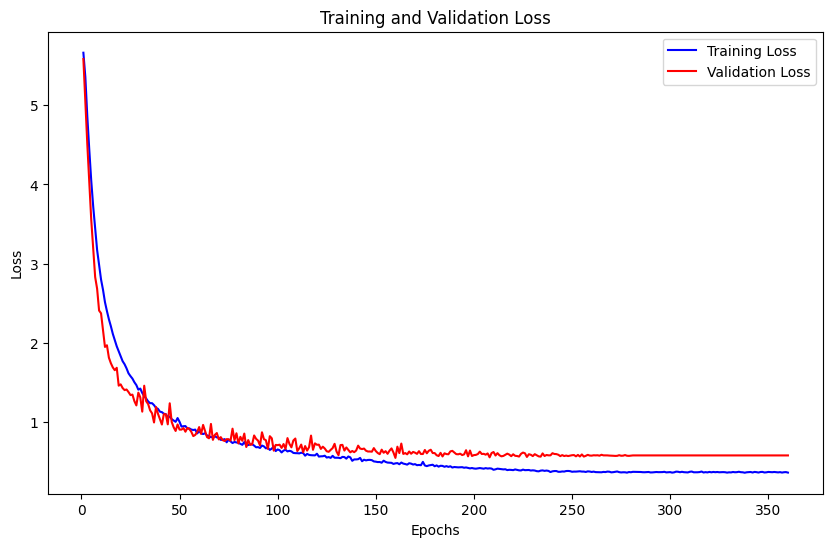

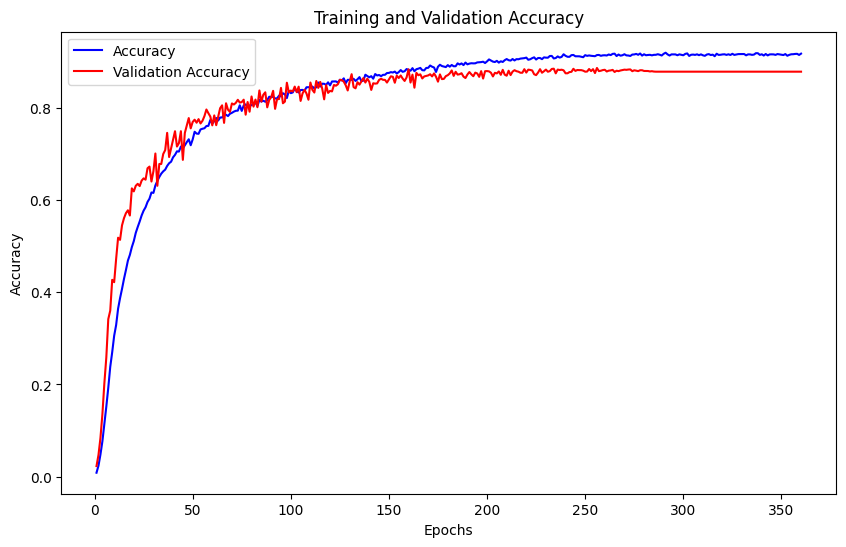

In [12]:
import matplotlib.pyplot as plt

# Assuming you have the accuracy values for each epoch in training and testing
# Replace train_accuracy and test_accuracy with your actual accuracy values

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'b', label='Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()